# Clustering Social Media Data

# Importing and cleaning the data

In [130]:
import numpy as np
import pandas as pd
import pickle
from os import path as Path

In [131]:
s3_data_dir="s3://ds-rg271/data"
s3_model_dir="s3://ds-rg271/models"

input_data_uri = Path.join(s3_data_dir,"labelled/mebank_tweets_1_year_labelled.csv")
print(input_data_uri)

s3://ds-rg271/data/labelled/mebank_tweets_1_year_labelled.csv


In [132]:
input_data=pd.read_csv(input_data_uri)

In [133]:
print(type(input_data))
input_data.tail()

<class 'pandas.core.frame.DataFrame'>


,Unnamed: 0,date,content,complaint,topic,content_type,user,url
892,892,2020-08-27 01:57:06+00:00,"@mebank Still crap. And yes, I've checked MY ...",1.0,Problem/System Down,twitter/mention,EightTwo5,https://twitter.com/EightTwo5/status/129880168...
893,893,2020-12-26 02:24:48+00:00,@mebank I understand that this must be a busy ...,1.0,Problem/Customer Service,twitter/mention,MarkTayar,https://twitter.com/MarkTayar/status/134265758...
894,894,2020-09-11 00:09:35+00:00,I am paying more on rent than on a 100% LVR pr...,0.0,NaN,twitter/mention,OnceANerd,https://twitter.com/OnceANerd/status/130421044...
895,895,2020-12-24 06:35:28+00:00,@mebank @DamienFarrugia Didn't get Mum a Chris...,1.0,Problem/Others,twitter/mention,LongyLonghorn,https://twitter.com/LongyLonghorn/status/13419...
896,896,2020-09-21 02:30:03+00:00,"ME Bank looks to e-signatures, digital loan pr...",0.0,NaN,twitter/mention,MrtgBusiness,https://twitter.com/MrtgBusiness/status/130786...


In [134]:
import datetime
import re

for i, date_str in enumerate(input_data['date']):
	date_str=re.sub('\+00:00', '', date_str)
	input_data.loc[i,'date']=datetime.datetime.strptime(date_str,'%Y-%m-%d %H:%M:%S')


In [135]:
# sorting data based on date
input_data_sorted=input_data.sort_values(by=['date'],ignore_index=True).reset_index(drop=True)
input_data_sorted.shape

(897, 8)

In [10]:
# removing 0.5 and -1 labels 
input_data_01=input_data_sorted[input_data_sorted.complaint.isin([0, 1])].reset_index(drop=True)
input_data_01.shape

(862, 8)

In [11]:
input_data_01.tail()

,Unnamed: 0,date,content,complaint,topic,content_type,user,url
857,550,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",0.0,NaN,twitter/mention,qnmuofficial,https://twitter.com/qnmuofficial/status/141815...
858,868,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,1.0,Problem/Customer Service,twitter/mention,heathwilder,https://twitter.com/heathwilder/status/1418355...
859,325,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,0.0,Inquiry,twitter/mention,spikeuk1982,https://twitter.com/spikeuk1982/status/1418561...
860,625,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,1.0,Problem/Others,twitter/mention,TheDadhiwala,https://twitter.com/TheDadhiwala/status/141873...
861,573,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,0.0,NaN,twitter/mention,sandybeech4,https://twitter.com/sandybeech4/status/1419226...


In [12]:
# Ensure all labels are the same by making them lower case and stripping trailing whitespace
input_data_01["topic"] = input_data_01["topic"].str.lower().str.strip()

# Ensure complaint is integer
input_data_01["complaint"] = input_data_01["complaint"].astype(int)

# Fix missed problem - other
input_data_01.loc[input_data_01["topic"] == "problem - other", "topic"] = "problem/others"

In [13]:
input_data_01.tail()

,Unnamed: 0,date,content,complaint,topic,content_type,user,url
857,550,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",0,NaN,twitter/mention,qnmuofficial,https://twitter.com/qnmuofficial/status/141815...
858,868,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,1,problem/customer service,twitter/mention,heathwilder,https://twitter.com/heathwilder/status/1418355...
859,325,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,0,inquiry,twitter/mention,spikeuk1982,https://twitter.com/spikeuk1982/status/1418561...
860,625,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,1,problem/others,twitter/mention,TheDadhiwala,https://twitter.com/TheDadhiwala/status/141873...
861,573,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,0,NaN,twitter/mention,sandybeech4,https://twitter.com/sandybeech4/status/1419226...


In [14]:
input_data_01.to_csv("../data/mebank_tweets_1_year_clean.csv", index=False)
input_data_01.to_csv(f"{s3_data_dir}/labelled/mebank_tweets_1_year_cleaned.csv", index=False)

Cleaning and preprocessing the input text

In [15]:
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'mebank','um','umm','ummm','hi','hello','hey','heyyyyy','fyi'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mahdi.rasouli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahdi.rasouli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#installing tweet-preprocessor
!pip install tweet-preprocessor

In [109]:
def preprocess_text(text, flg_clean=True, flg_tweet=True, flg_stemm=False, flg_lemm=False, lst_stopwords=None):

	## Tweet preprocessor
	if flg_tweet == True:
		import preprocessor as p
		# remove url, mention,emoji, smily, and numbers (keeping hashtags)
		p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER)
		text=p.clean(text)

	## Tweet preprocessor
	if flg_clean == True:

		# Remove mentions
		text = re.sub(r'/^(?!.*\bRT\b)(?:.+\s)?@\w+/i', '', text)
		text = re.sub('@', '', text)
		
		# Replace Emails
		text = re.sub('\S*@\S*\s?', '', text)

		# Remove links
		text = re.sub('http\S*', '', text)

		# clean hashtags (just removing the hashtag)
		# #text = re.sub('#\S*', '', text)
		text = re.sub('#', '', text)

		# Remove unacceptable characters/emojis
		text = re.sub('\S*ü\S*\s?', '', text)
		text = re.sub('\S*ò\S*\s?', '', text)
		text = re.sub('\S*ä\S*\s?', '', text)
		text = re.sub('\S*ô\S*\s?', '', text)


		# Remove new line characters
		text = re.sub('\s+', ' ', text)

		# convert to lower case
		text=text.lower()

		## clean (convert to lowercase and remove punctuations and characters and then strip)
		#text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
		
		# Remove distracting single quotes
		#text = [re.sub("\'", "", sent) for sent in text]

			
	## Tokenize (convert from string to list)
	lst_text = text.split()    ## remove Stopwords

	if lst_stopwords is not None:
		lst_text = [word for word in lst_text if word not in lst_stopwords]
		
	## Stemming (remove -ing, -ly, ...)
	if flg_stemm == True:
		ps = nltk.stem.porter.PorterStemmer()
		lst_text = [ps.stem(word) for word in lst_text]
		
	## Lemmatisation (convert the word into root word)
	if flg_lemm == True:
		lem = nltk.stem.wordnet.WordNetLemmatizer()
		lst_text = [lem.lemmatize(word) for word in lst_text]
		
	## back to string from list
	text = " ".join(lst_text)
	
	return text

In [110]:
preprocess_text('yes @marchall. #mebank #route http:yes.com mebank not playing umm we would look into these \n yes, 2nd line 1200', \
	flg_tweet=True, flg_clean=True, flg_stemm=False, flg_lemm=True, lst_stopwords=None)

'yes . mebank route mebank not playing umm we would look into these yes, nd line'

In [111]:
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER)
p.clean('yes system down. @marchall #mebank #route http:yes.com mebank Not noot playing umm we would look into these \n yes, 2nd line 1200')


'yes system down. #mebank #route mebank Not noot playing umm we would look into these yes, nd line'

In [112]:
input_data_clean=input_data_01.copy()
print(input_data_clean.shape)


(862, 8)


In [113]:
input_data_clean.tail()

,Unnamed: 0,date,content,complaint,topic,content_type,user,url
857,550,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...",0,NaN,twitter/mention,qnmuofficial,https://twitter.com/qnmuofficial/status/141815...
858,868,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,1,problem/customer service,twitter/mention,heathwilder,https://twitter.com/heathwilder/status/1418355...
859,325,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,0,inquiry,twitter/mention,spikeuk1982,https://twitter.com/spikeuk1982/status/1418561...
860,625,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,1,problem/others,twitter/mention,TheDadhiwala,https://twitter.com/TheDadhiwala/status/141873...
861,573,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,0,NaN,twitter/mention,sandybeech4,https://twitter.com/sandybeech4/status/1419226...


In [114]:
for i in range(0,len(input_data_clean['content'])):
	input_data_clean.loc[i,'content_clean']=preprocess_text(input_data_clean.loc[i,'content'], flg_clean=True, flg_tweet=True, flg_stemm=False, flg_lemm=False, lst_stopwords=None)


In [115]:
input_data_clean=input_data_clean[['date','content','content_clean','complaint','topic']]
input_data_clean.tail()

,date,content,content_clean,complaint,topic
857,2021-07-22 10:15:06,"Congrats to Ella Van De Velde Fidock, Register...","congrats to ella van de velde fidock, register...",0,NaN
858,2021-07-22 23:39:22,@mebank How do you justify taking 3 weeks to g...,how do you justify taking weeks to generate an...,1,problem/customer service
859,2021-07-23 13:21:12,@mebank So... do you have a timeframe when is ...,so... do you have a timeframe when is prefill ...,0,inquiry
860,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,so made me come all the way to police station ...,1,problem/others
861,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,making beautiful banking and helping australia...,0,NaN


In [116]:
#saving the cleaned data
input_data_clean.to_csv("../data/mebank_tweets_1_year_preprocessed.csv", index=False)
input_data_clean.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_1_year_preprocessed.csv", index=False)


# Generating embeddings 

In [117]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

In [118]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-mpnet-base-v2")

In [35]:
embeddings_clean = model.encode(input_data_clean["content_clean"].values)

In [36]:
input_data_clean['embedding']=list(embeddings_clean)

In [37]:
input_data_clean.sample(5)

,date,content,content_clean,complaint,topic,embedding
310,2020-12-18 05:13:45,@mebank you are timing out my session before I...,you are timing out my session before i receive...,1,problem/system down,"[0.03440372, -0.25458863, -0.034372117, 0.0369..."
175,2020-10-09 05:00:40,@GreaterBankAU @PayPalAU @gmail @Gumtree @meba...,we still haven't received the promised follow ...,1,problem/customer service,"[0.18667202, 0.23184596, -0.0053819898, 0.0987..."
486,2021-02-22 04:11:23,@troutish @mebank Same,same,0,NaN,"[0.0012113638, -0.009953201, -0.107804336, 0.0..."
617,2021-04-06 03:42:17,@mebank been on hold for 1.5 hrs. Not good en...,been on hold for hrs. not good enough!!!!,1,problem/customer service,"[-0.11841717, 0.06960528, -0.12817976, -0.0100..."
260,2020-11-20 05:21:50,@mebank perhaps you can be thrilled to bits su...,perhaps you can be thrilled to bits supporting...,1,problem/transaction,"[0.013891278, -0.049483497, 0.017201724, -0.00..."


In [38]:
#saving the data into local location
input_data_clean.to_csv("../data/mebank_tweets_1_year_embeddings.csv")
input_data_clean.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_1_year_embeddings.csv", index=False)

In [39]:
# saving the model locally
import pickle 

pickle.dump(model, open(f"../models/unsupervised/sent_transformer.sav", 'wb'))
#pickle.dump(model, open(f"{s3_model_dir}/unsupervised/sent_transformer.sav", 'wb'))

# Splitting the data


Splitting the data for unsupervised clustering (comparing over time)

In [60]:
import datetime

input_data_2020 = input_data_clean[(input_data_clean['date']> datetime.datetime(year=2020,month=1,day=1)) \
	& (input_data_clean['date']< datetime.datetime(year=2021,month=1,day=1))]

input_data_2021 = input_data_clean[(input_data_clean['date']>= datetime.datetime(year=2021,month=1,day=1))]

# Descriptive Statistics

In [42]:
input_data_clean.describe()

,complaint
count,862.000000
mean,0.361949
std,0.480843
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [43]:
#dataset["topic"]=dataset['topic'].fillna('NA')
input_data_clean["topic"].value_counts()

problem/customer service      76
problem/system down           74
problem/others                50
problem/app                   33
problem/transaction           31
problem/financial products    29
inquiry                        7
feature request                7
problem/website                5
others                         5
problem/atm                    2
fraud                          2
sustainability                 2
Name: topic, dtype: int64

# Visualizing data using t-SNE

Installing and importing necessary libraries

In [119]:
!pip install sklearn
!pip install hdbscan
!pip install matplotlib

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Configuring plot settings

In [121]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

# T-SNE visualisation

In [125]:
#dataset=pd.read_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_1_year_embeddings.csv")
dataset=input_data_clean
dataset.head(5)

,date,content,content_clean,complaint,topic
0,2020-07-27 07:35:23,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,0,NaN
1,2020-07-27 13:13:48,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree. take your money out of ing peeps and lo...,0,NaN
2,2020-07-28 03:25:01,"According to new research by @mebank, the #Cov...","according to new research by , the covid-19 pa...",0,NaN
3,2020-07-28 03:25:01,"According to new research by @mebank, the #Cov...","according to new research by , the covid-19 pa...",0,NaN
4,2020-07-29 02:08:50,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,0,NaN


In [129]:
# data check
print(type(embeddings_clean))
print(embeddings_clean.shape)

x=dataset['embedding']
#print(type(x))
#print(x.shape)


<class 'numpy.ndarray'>
(862, 768)


KeyError: 'embedding'

In [1991]:
tsne_projection = TSNE().fit_transform(dataset['embedding'].values.tolist())

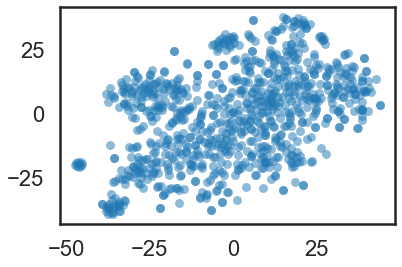

In [1992]:
plt.scatter(*tsne_projection.T, **plot_kwds)

# HDBSCAN Clustering

In [1993]:
import hdbscan

In [1999]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, prediction_data=True).fit(dataset['embedding'].values.tolist())

In [2000]:
clusterer.labels_

array([-1, -1,  5,  5, -1, -1, 15, 15, -1, -1, -1,  1, -1, -1, -1,  5,  5,
       -1, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 17, -1, -1, -1, -1, -1, 15,
       -1, -1, -1, -1, -1, -1, -1, -1, 18, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  4, -1, 17, -1, 15, -1, 15, -1, -1,
       -1, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 16, -1, -1,
       -1, -1, -1, -1, -1, -1,  8, -1,  8,  1,  8, 15, -1,  8, -1, -1, -1,
       -1,  4, 18, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [2001]:
n_clusters = clusterer.labels_.max

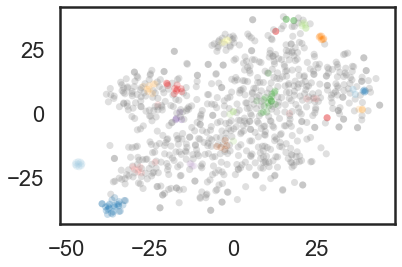

In [2002]:
color_palette = sns.color_palette('Paired', 24)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*tsne_projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

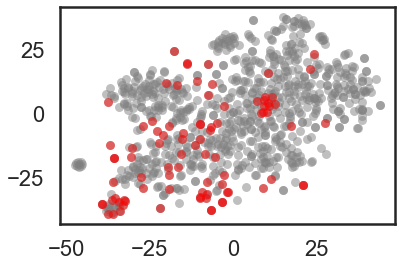

In [2713]:
#plotting detected outliers

threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*tsne_projection.T, c='gray', **plot_kwds)
plt.scatter(*tsne_projection[outliers].T, c='red', **plot_kwds)

In [2004]:
#cluster_membership=pd.DataFrame(zip(clusterer.labels_, clusterer.probabilities_, clusterer.outlier_scores_))

In [1674]:
# plotting outlier scores
#sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

Testing new data points

In [2005]:
# just a test sample
test_data=[embeddings_clean[11]]

In [2006]:
#Predicting clusters for new points
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_data)
test_labels

array([1])

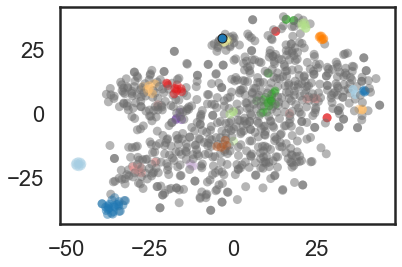

In [2007]:
#plotting new data
pal = sns.color_palette('Paired', 24)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(*tsne_projection.T, c=colors, **plot_kwds);
plt.scatter(*tsne_projection[33].T, c=test_colors, s=80, linewidths=1, edgecolors='k')

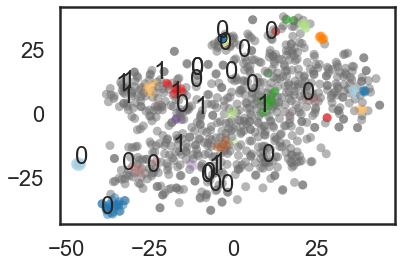

In [2008]:
#plotting labels
pal = sns.color_palette('Paired', 24)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
plt.scatter(*tsne_projection.T, c=colors, **plot_kwds);
plt.scatter(*tsne_projection[33].T, c=test_colors, s=80, linewidths=1, edgecolors='k')

for i in range(30,60):

    label = "{:.0f}".format(dataset['complaint'][i])

    plt.annotate(label, # this is the text
                 tsne_projection[i], # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

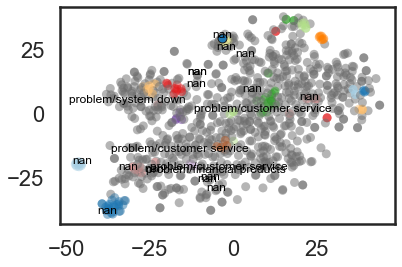

In [2010]:
#plotting labels
pal = sns.color_palette('Paired', 24)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
plt.scatter(*tsne_projection.T, c=colors, **plot_kwds);
plt.scatter(*tsne_projection[33].T, c=test_colors, s=80, linewidths=1, edgecolors='k')

for i in range(30,50):

    label = "{}".format(dataset['topic'][i])

    plt.annotate(label, # this is the text
                 tsne_projection[i], # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

Adjusting clusters

<AxesSubplot:ylabel='$\\lambda$ value'>

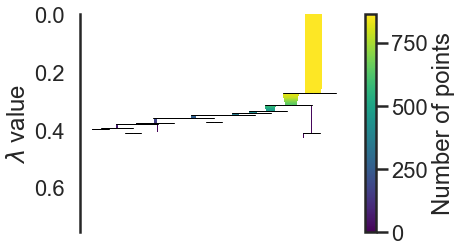

In [1246]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='distance'>

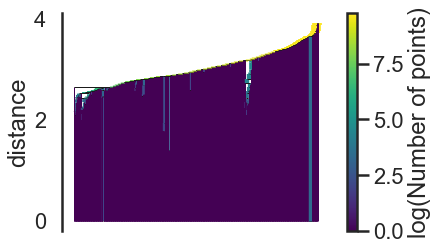

In [1247]:
clusterer.single_linkage_tree_.plot()

In [ ]:
clusterer.single_linkage_tree_.get_clusters(3, min_cluster_size=5)

# UMAP & HDBSCAN

Importing required libraries

In [ ]:
!pip install umap-learn
#python -m pip install umap

In [2011]:
#Dimension reduction and clustering libraries
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Generating UMAP Projections

In [2387]:
# Define UMAP model to reduce embeddings dimension
umap_model = umap.UMAP(n_neighbors=20,
                       n_components=10,
                       min_dist=0,
                       metric='cosine',
                       low_memory=False,
                      )

In [2388]:
umap_embeddings=umap_model.fit_transform(dataset['embedding'].values.tolist())

Clusterin umap projections using hdbscan

In [2393]:
# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=8,
                                min_samples=8,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True,
                               )

In [2394]:
hdbscan_cluster = hdbscan_model.fit(umap_embeddings)

In [2395]:
hdbscan_cluster.labels_

array([11,  1, 14, 14, -1, -1, 14, 14, 14,  5, -1,  0, 14, -1, -1, 14, 14,
       14, 17, 17, 14,  5,  8, 14, 13,  5, 11, -1, 17, 15, 11, -1, 14,  1,
       17, -1, -1, -1, -1, -1, 16, 16,  1, 15,  6, 17,  6,  0,  3, 16, 16,
       -1, -1,  8,  5,  6,  6,  6, -1,  6, 15,  6, 16, 15, -1,  6, 17, 14,
       17, 17,  5,  5, -1,  5,  5,  6,  6,  6,  7, 17,  6,  6,  6,  6,  6,
       -1, -1,  6, -1, -1,  6, 15,  4, 17,  5,  6, -1, 14, 14, 14, 14, 16,
       -1, 14,  8, 14, 14, 14, -1, 14, -1, -1, -1, -1, 12, 14, 12, 17, -1,
       -1, -1, 14, -1, 17, -1, 14, 16,  2, 11,  1, -1, -1,  0, 17,  1, 10,
       14,  0,  5, -1, 10,  2, 14, 14, -1, -1,  5, -1, -1, 11, -1, 16, -1,
        6, -1, -1, -1, -1, -1, -1, -1, -1, 12, 12, -1, 17, -1, 11,  6, -1,
       17, 15, -1, 15, -1, 15, 15, -1, 15,  0, 15, 14, -1, 15, -1, -1,  6,
        5, 17,  6, -1, -1, 15, -1, 15,  6, 13, -1, -1, -1,  4, -1,  8, 15,
       -1,  4, -1,  5, 15, 14, -1, 14, 14, 16, 11, 14, 14, -1, -1,  8, -1,
       -1, -1, -1, 14, 15

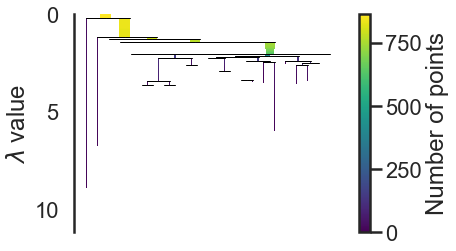

In [2396]:
cluster_labels=hdbscan_cluster.condensed_tree_.plot()

In [2397]:
#cluster_labels=hdbscan_cluster.single_linkage_tree_.get_clusters(0.4, min_cluster_size=5)
#cluster_labels

In [2398]:
hdbscan_cluster.cluster_persistence_

array([0.70994924, 0.52979182, 0.69849274, 0.43051311, 0.03530261,
       0.18789414, 0.09434598, 0.11772313, 0.08964758, 0.01204404,
       0.26317496, 0.12294413, 0.09796016, 0.06880562, 0.04468118,
       0.06443212, 0.07152044, 0.13846919])

In [2399]:
results=dataset

results['umap_projections']=list(umap_embeddings)
results['cluster']=hdbscan_cluster.labels_
results['cluster_probability']=hdbscan_cluster.probabilities_
results['outlier_score']=hdbscan_cluster.outlier_scores_

results.sample(5)


,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
199,2020-10-31 01:11:26,@mebank Yes - I can read instructions and unde...,yes - i can read instructions and undertake re...,1,problem/customer service,"[-0.06883988, 0.021882832, 0.022519644, -0.036...","[14.466173, 1.8384541, 8.02872, 8.049083, 6.55...",-1,0.000000,0.051262
856,2021-07-22 06:58:58,"@mebank hey Andy, I spoke to one already and h...","hey andy, i spoke to one already and he essent...",1,problem/financial products,"[-0.00041636298, 0.086183645, -0.025247654, 0....","[16.192442, 1.2504857, 7.193936, 9.672871, 7.4...",-1,0.000000,0.015507
233,2020-11-08 22:47:55,@DaveK76 @CommBank @NAB @Westpac @ANZ_AU @meba...,hi on wednesday we will be lauching our lowest...,0,NaN,"[-0.12534377, -0.24530677, 0.004864877, -0.233...","[17.185822, 1.3947301, 7.5611625, 9.585617, 7....",14,1.000000,0.000000
726,2021-05-27 01:15:18,Really disappointed that @mebank has chosen to...,really disappointed that has chosen to go down...,1,problem/others,"[-0.080109626, -0.07135925, 0.05591441, -0.068...","[16.825207, 1.5520073, 7.1978774, 9.794159, 7....",14,1.000000,0.107675
507,2021-02-23 00:55:59,@jesshodder Sound reasons. They were my origin...,sound reasons. they were my original reasons f...,0,NaN,"[-0.047672343, 0.18276063, 0.0047235764, 0.040...","[16.874365, 0.87386227, 7.162633, 10.208833, 7...",11,0.588818,0.411182


In [2400]:
#finding outliers
outliers=results.loc[results['cluster'].isin([-1])]
outliers.sample(5)

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
449,2021-02-18 23:43:03,That‚Äôs a bit of a shocker! I chose @mebank b...,thats a bit of a shocker! i chose because it i...,0,NaN,"[0.10920194, -0.14657852, -0.06292153, 0.05438...","[16.439386, 0.5565521, 7.1202745, 10.237417, 8...",-1,0.0,0.053257
376,2021-01-12 07:03:15,Meant to settle on a property in 2 days but @m...,meant to settle on a property in days but have...,1,problem/customer service,"[-0.020202255, 0.20186362, 0.00967112, 0.06185...","[16.457012, 2.028225, 7.5249615, 9.172119, 6.8...",-1,0.0,0.280733
475,2021-02-22 01:55:06,@mebank My initial reaction is that I‚Äôm not ...,my initial reaction is that im not happy being...,1,problem/others,"[0.0042478023, -0.03128264, 0.027762419, 0.015...","[16.631927, 1.164216, 7.1924644, 10.006387, 7....",-1,0.0,0.041378
466,2021-02-22 00:09:32,Ohh the copy writing at @mebank is a lot more ...,ohh the copy writing at is a lot more fun sinc...,0,NaN,"[0.12995481, -0.043433268, 0.0041879467, -0.04...","[15.989361, 1.0253634, 7.302442, 9.654182, 7.5...",-1,0.0,0.016515
118,2020-09-02 00:27:58,@financetrollau @UBank @ING_Aust @BankofMelb @...,good point. though that's also true of any non...,0,NaN,"[-0.05613078, 0.16300431, -0.018999588, 0.0533...","[16.839577, 1.0929135, 7.3946815, 9.763391, 7....",-1,0.0,0.029793


In [2409]:
#clustered data
clustered = results.loc[~results['cluster'].isin([-1])]
clustered.sort_values(by='cluster')[250:300]


,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
267,2020-11-22 23:00:44,@mebank it looks like our BSB has changed with...,it looks like our bsb has changed without any ...,1,problem/others,"[-0.023596298, -0.034562252, -0.028097901, -0....","[16.242483, 2.2202032, 7.5265384, 8.759978, 7....",8,0.890717,0.109283
325,2020-12-24 08:47:21,@mebank Any update to the ATM withdrawal issue?,any update to the atm withdrawal issue?,1,problem/atm,"[0.01027773, -0.28615764, 0.060450662, 0.04836...","[16.271036, 2.1850138, 7.33892, 8.948852, 6.86...",8,0.874255,0.125745
257,2020-11-17 08:57:44,"@mebank No worries, thank you. You might be ab...","no worries, thank you. you might be able to he...",0,NaN,"[0.12740913, -0.07594652, -0.010200422, -0.002...","[16.293535, 2.2497084, 7.422987, 8.807299, 6.9...",8,0.999811,0.000189
331,2020-12-26 09:33:38,@mebank Is there something wrong?? Periodic p...,is there something wrong?? periodic payments n...,1,problem/system down,"[0.079380274, 0.017018614, 0.034419127, 0.1590...","[16.257267, 2.1486235, 7.496647, 8.844066, 6.9...",8,0.999811,0.000189
560,2021-03-05 02:52:03,"@mebank hey there, any plans to introduce SMS ...","hey there, any plans to introduce sms notifica...",1,feature request,"[0.026998159, -0.005227975, 0.045589548, -0.00...","[16.246552, 2.1505458, 7.317303, 8.93097, 6.89...",8,0.812543,0.187457
685,2021-05-07 23:30:54,@mebank is there any problems with eftpos this...,is there any problems with eftpos this morning...,1,problem/transaction,"[0.012950417, -0.20615287, 0.011846753, 0.0677...","[16.305815, 2.2211883, 7.5607543, 8.943992, 6....",8,0.988223,0.011777
677,2021-05-06 02:45:51,@mebank Still not seeing funds in the destinat...,still not seeing funds in the destination acco...,1,problem/transaction,"[0.11166688, -0.13550593, 0.10276719, 0.096697...","[16.342262, 2.1734662, 7.3724837, 8.940223, 6....",8,1.000000,0.000000
776,2021-06-17 05:37:14,Nearly every bank Australia wide is down. Sit ...,nearly every bank australia wide is down. sit ...,0,NaN,"[-0.13071015, -0.090236805, -0.084466, -0.0493...","[16.523493, 0.455278, 6.4753814, 10.597944, 7....",9,1.000000,0.000000
437,2021-02-15 21:17:38,Three freaky banking industry exits in three w...,three freaky banking industry exits in three w...,0,NaN,"[-0.06433522, -0.038842496, -0.054154735, 0.03...","[16.532373, 0.46004146, 6.489815, 10.594678, 8...",9,1.000000,0.000000
782,2021-06-17 06:18:14,#Alert - Systems for major banks and organisat...,alert - systems for major banks and organisati...,0,NaN,"[-0.13244279, -0.20538299, 0.017438961, -0.026...","[16.518272, 0.44614437, 6.455333, 10.619713, 7...",9,1.000000,0.000000


In [2412]:
#SAVING RESULTS
results.sort_values(by='date')
results.to_csv('../data/results_sorted_by_date.csv', index=False)
results.to_csv(f"{s3_data_dir}/results/mebank_tweets_clusters_sorted_by_date.csv",index=False)

In [2413]:
#SAVING RESULTS
results_cluster_sorted=results.sort_values(by='cluster')
results_cluster_sorted.to_csv('../data/results_sorted_by_cluster.csv', index=False)
results_cluster_sorted.to_csv(f"{s3_data_dir}/results/mebank_tweets_clusters_sorted_by_cluster.csv",index=False)


VISUALIZATION - TO BE UPDATED


In [ ]:
# TO BE MODIFIED
fig, ax = plt.subplots(figsize=(20, 10))

#threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
#outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
#outliers = np.where(hdbscan_cluster.labels_ == -1)
#outliers = results.loc[results.cluster == -1, :]
plt.scatter(outliers['umap_projections'][:,0], outliers['umap_projections'][:,1], color='#BDBDBD', s=0.05)
plt.scatter(clustered['umap_projections'][:,0], clustered['umap_projections'][:,1], c=clustered['cluster'], s=0.5, cmap='hsv_r')
plt.colorbar()

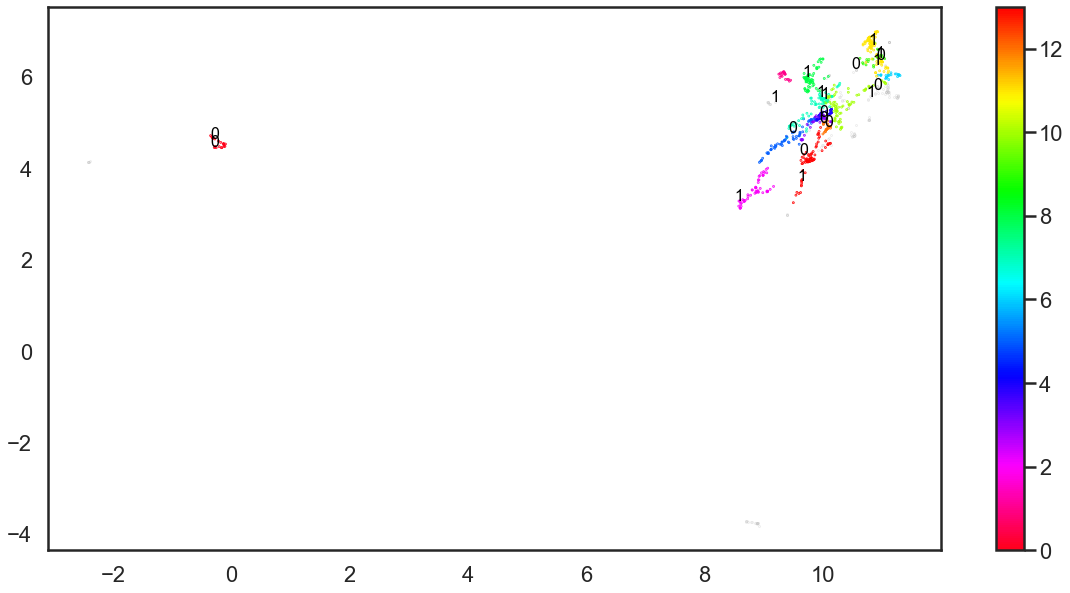

In [584]:
# Visualize cluster and labels 
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()


#plotting labels
for i in range(10,30):

    label = "{:.0f}".format(dataset['complaint'][i])

    plt.annotate(label, # this is the text
                 (result['x'][i],result['y'][i]), # these are the coordinates to position the label
                 color='black',
                 size=16,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

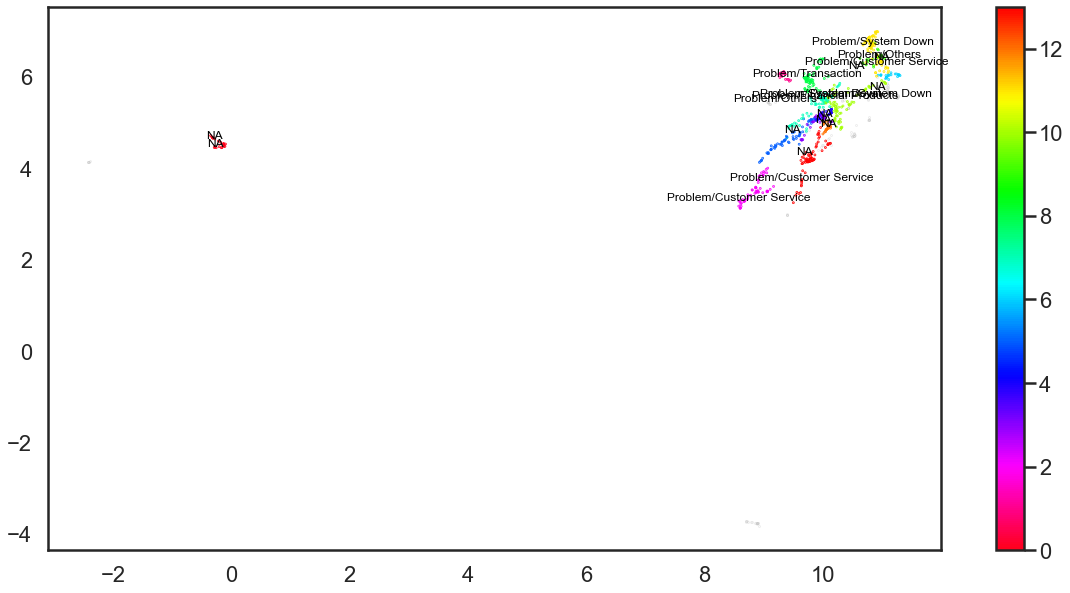

In [585]:
# Visualize cluster and labels 
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()


#plotting labels
for i in range(10,30):

    label = "{}".format(dataset['topic'][i])

    plt.annotate(label, # this is the text
                 (result['x'][i],result['y'][i]), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

# Quantitative Model Evaluation

In [586]:
#from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

#adjusted_rand_score(dataset['topic'], result['labels']), adjusted_mutual_info_score(dataset['topic'], result['labels'])

(0.031164243259547558, 0.20168266687017464)

# Topic Modelling

In [2620]:
results.sample()

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
330,2020-12-26 06:02:53,Waited nearly 5hrs until call centre closed wi...,waited nearly hrs until call centre closed wit...,1,problem/customer service,"[0.0027350865, 0.084130794, -0.123149775, -0.0...","[15.05861, 1.942001, 7.473486, 8.569833, 6.485...",15,1.0,0.029746


In [2621]:
docs_df= pd.DataFrame()
docs_df['Doc']=results['content']
docs_df['Doc_Clean']=results['content_clean']
docs_df['Topic'] = results['cluster']
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic_raw = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic_clean = docs_df.groupby(['Topic'], as_index = False).agg({'Doc_Clean': ' '.join})
docs_per_topic=pd.merge(docs_per_topic_raw, docs_per_topic_clean, on=["Topic"])

In [2622]:
docs_per_topic.sample(3)

,Topic,Doc,Doc_Clean
13,12,@TMFScottP @UBank @ING_Aust @BankofMelb @StGeo...,ubank is nab? bom and st george owned by westp...
4,3,@Aaron_Dodd2 @CommBank @SkyNewsAust @mebank @m...,indeed. need
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...


In [2623]:
# Creating a variable for results
clustering_results=docs_per_topic

In [2624]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc_Clean.values, m=len(dataset))

In [2625]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc_Clean
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc_Clean": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)

In [2626]:
top_n_words[8]

[('account', 0.05756887096555023),
 ('deposited', 0.04141010334908519),
 ('payments', 0.03902895057381005),
 ('transfers', 0.03516015948614623),
 ('accounts', 0.033366265940841654),
 ('bsb', 0.03272047966471436),
 ('funds', 0.03203533782445613),
 ('bank accounts', 0.03105757751181389),
 ('transfer', 0.0298179846841428),
 ('issue', 0.028629925494722697)]

In [2627]:
np.array(top_n_words[-1])[:,0]
#list(np.array(top_n_words[-1])[:,1])

array(['bank', 'loan', 'customer', 'banking', 'account', 'like', 'thanks',
       'good', 'amp', 'customers'], dtype='<U32')

In [2628]:
x=dict({'a':2, 'b':3})
y=x.values()
y

dict_values([2, 3])

In [2629]:
clustering_results['cluster_size']=topic_sizes['Size']

for i,topic in enumerate(clustering_results['Topic']):
	clustering_results.loc[i,'top_words']=str(list(np.array(top_n_words[topic])[:,0]))
	clustering_results.loc[i,'top_words_score']=str(top_n_words[topic])


clustering_results

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,258,"['bank', 'loan', 'customer', 'banking', 'accou...","[('bank', 0.011085242304165676), ('loan', 0.01..."
1,0,Nominate an organisation or team in the aged c...,nominate an organisation or team in the aged c...,25,"['awards', '000', 'hesta', 'nominate', '000 pr...","[('awards', 0.07246765771153867), ('000', 0.06..."
2,1,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree. take your money out of ing peeps and lo...,25,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...","[('fossil', 0.12288920390364519), ('fuels', 0...."
3,2,I am paying more on rent than on a 100% LVR pr...,i am paying more on rent than on a % lvr prope...,19,"['property', 'home buyers', 'realestate', 'mar...","[('property', 0.08806075349399949), ('home buy..."
4,3,@Aaron_Dodd2 @CommBank @SkyNewsAust @mebank @m...,indeed. need,11,"['need', 'zip files', 'faster', 'fast payments...","[('need', 3.5403794457954922), ('zip files', 0..."
5,4,@mebank Time to leave MeBank... 2nd time I hav...,time to leave mebank... nd time i haven't been...,13,"['logon', 'code', 'mebank', 'bankingcommission...","[('logon', 0.07127774890283174), ('code', 0.06..."
6,5,"@mebank Hi, with your internet banking, for Pa...","hi, with your internet banking, for pay anyone...",22,"['pay', 'payments', 'apple pay', 'apple', 'goo...","[('pay', 0.06741982485373604), ('payments', 0...."
7,6,@mebank has your online services on down ? I c...,has your online services on down ? i can't sig...,102,"['app', 'internet', 'internet banking', 'banki...","[('app', 0.07468545147239454), ('internet', 0...."
8,7,@mebank are debit cards working? https://t.co/...,"are debit cards working? yes, i've had that ha...",17,"['card', 'replacement', 'having', 'issues', 'a...","[('card', 0.10129074858720848), ('replacement'..."
9,8,@danielbowen @mebank Wow amazing! Has @mebank ...,wow amazing! has finally stopped sending the r...,23,"['account', 'deposited', 'payments', 'transfer...","[('account', 0.05756887096555023), ('deposited..."


In [ ]:
# if using gensim for cluster summary
#!pip install gensim==3.8.3

In [ ]:
# if using pysummarization for cluster summary
!pip install pysummarization

In [2630]:
# CREATING CUMMARY FOR TOPIC CLUSTERS (Possible solutions: gensim, pysummarization, transformers summerization, ... )

#from gensim.summarization.summarizer import summarize as gensim_summarize	
from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor
from operator import itemgetter


def get_summary(text):
	
	#using gensim -> depreciated: did not work properly, suggested to use version 3.4 or less
	#text_summary=summarize(text, ratio=0.2, word_count=None, split=False)

	#using pysummerization library
	# Object of automatic summarization.
	auto_abstractor = AutoAbstractor()
	# Set tokenizer.
	auto_abstractor.tokenizable_doc = SimpleTokenizer()
	# Set delimiter for making a list of sentence.
	auto_abstractor.delimiter_list = [".", "\n"]
	# Object of abstracting and filtering document.
	abstractable_doc = TopNRankAbstractor()

	# Summarize document.
	result_dict = auto_abstractor.summarize(text, abstractable_doc)
	
	# Extracting the highest score sentence
	max_index=max(result_dict['scoring_data'],key=itemgetter(1))[0]
	max_sen=result_dict['summarize_result'][max_index]

	return max_sen


# there is an issue with length of bigger length of Doc.
for i,doc in enumerate(clustering_results['Doc_Clean']):
	clustering_results.loc[i,'summary_pysummarization']=get_summary(doc[:500])


clustering_results

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_pysummarization
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,258,"['bank', 'loan', 'customer', 'banking', 'accou...","[('bank', 0.011085242304165676), ('loan', 0.01...",how can i change my tax status so ubank withh...
1,0,Nominate an organisation or team in the aged c...,nominate an organisation or team in the aged c...,25,"['awards', '000', 'hesta', 'nominate', '000 pr...","[('awards', 0.07246765771153867), ('000', 0.06...",nominate an organisation or team in the aged c...
2,1,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree. take your money out of ing peeps and lo...,25,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...","[('fossil', 0.12288920390364519), ('fuels', 0....","don't , neither do auspol ausbiz climatecrisi..."
3,2,I am paying more on rent than on a 100% LVR pr...,i am paying more on rent than on a % lvr prope...,19,"['property', 'home buyers', 'realestate', 'mar...","[('property', 0.08806075349399949), ('home buy...",the great aussie dream of home ownership is s...
4,3,@Aaron_Dodd2 @CommBank @SkyNewsAust @mebank @m...,indeed. need,11,"['need', 'zip files', 'faster', 'fast payments...","[('need', 3.5403794457954922), ('zip files', 0...",indeed.\n
5,4,@mebank Time to leave MeBank... 2nd time I hav...,time to leave mebank... nd time i haven't been...,13,"['logon', 'code', 'mebank', 'bankingcommission...","[('logon', 0.07127774890283174), ('code', 0.06...",given how many times and on how many platform...
6,5,"@mebank Hi, with your internet banking, for Pa...","hi, with your internet banking, for pay anyone...",22,"['pay', 'payments', 'apple pay', 'apple', 'goo...","[('pay', 0.06741982485373604), ('payments', 0....","hi, with your internet banking, for pay anyone..."
7,6,@mebank has your online services on down ? I c...,has your online services on down ? i can't sig...,102,"['app', 'internet', 'internet banking', 'banki...","[('app', 0.07468545147239454), ('internet', 0....",thanks! is there a reason your app won't load...
8,7,@mebank are debit cards working? https://t.co/...,"are debit cards working? yes, i've had that ha...",17,"['card', 'replacement', 'having', 'issues', 'a...","[('card', 0.10129074858720848), ('replacement'...","so my card expires /21, does that mean i am n..."
9,8,@danielbowen @mebank Wow amazing! Has @mebank ...,wow amazing! has finally stopped sending the r...,23,"['account', 'deposited', 'payments', 'transfer...","[('account', 0.05756887096555023), ('deposited...",wow amazing! has finally stopped sending the r...


In [2639]:
# SUMMARY USING TRANSFORMERS
from transformers import pipeline
summerizer=pipeline('summarization')

for i,doc in enumerate(clustering_results['Doc_Clean']):
	clustering_results.loc[i,'summary_transformers']=summerizer(doc[:1024], max_length=50, min_length=5, do_sample=False)[0]['summary_text']



Your max_length is set to 50, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [2640]:
clustering_results

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_pysummarization,summary_transformers
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,258,"['bank', 'loan', 'customer', 'banking', 'accou...","[('bank', 0.011085242304165676), ('loan', 0.01...",how can i change my tax status so ubank withh...,i might be a non-resident for tax purposes bu...
1,0,Nominate an organisation or team in the aged c...,nominate an organisation or team in the aged c...,25,"['awards', '000', 'hesta', 'nominate', '000 pr...","[('awards', 0.07246765771153867), ('000', 0.06...",nominate an organisation or team in the aged c...,"$30,000 prize pool is up for grabs for the he..."
2,1,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree. take your money out of ing peeps and lo...,25,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...","[('fossil', 0.12288920390364519), ('fuels', 0....","don't , neither do auspol ausbiz climatecrisi...",i'm already ditching my account and credit ca...
3,2,I am paying more on rent than on a 100% LVR pr...,i am paying more on rent than on a % lvr prope...,19,"['property', 'home buyers', 'realestate', 'mar...","[('property', 0.08806075349399949), ('home buy...",the great aussie dream of home ownership is s...,auspol . has launched a special discount offe...
4,3,@Aaron_Dodd2 @CommBank @SkyNewsAust @mebank @m...,indeed. need,11,"['need', 'zip files', 'faster', 'fast payments...","[('need', 3.5403794457954922), ('zip files', 0...",indeed.\n,There is no need to be a need for such a thin...
5,4,@mebank Time to leave MeBank... 2nd time I hav...,time to leave mebank... nd time i haven't been...,13,"['logon', 'code', 'mebank', 'bankingcommission...","[('logon', 0.07127774890283174), ('code', 0.06...",given how many times and on how many platform...,time to leave mebank... nd time i haven't bee...
6,5,"@mebank Hi, with your internet banking, for Pa...","hi, with your internet banking, for pay anyone...",22,"['pay', 'payments', 'apple pay', 'apple', 'goo...","[('pay', 0.06741982485373604), ('payments', 0....","hi, with your internet banking, for pay anyone...",Google has launched googlepay as another cash...
7,6,@mebank has your online services on down ? I c...,has your online services on down ? i can't sig...,102,"['app', 'internet', 'internet banking', 'banki...","[('app', 0.07468545147239454), ('internet', 0....",thanks! is there a reason your app won't load...,your online banking is down again including t...
8,7,@mebank are debit cards working? https://t.co/...,"are debit cards working? yes, i've had that ha...",17,"['card', 'replacement', 'having', 'issues', 'a...","[('card', 0.10129074858720848), ('replacement'...","so my card expires /21, does that mean i am n...","are debit cards working? yes, i've had that h..."
9,8,@danielbowen @mebank Wow amazing! Has @mebank ...,wow amazing! has finally stopped sending the r...,23,"['account', 'deposited', 'payments', 'transfer...","[('account', 0.05756887096555023), ('deposited...",wow amazing! has finally stopped sending the r...,Is there a reason why the scheduled account t...


In [2641]:
results_cluster_sorted.sample()

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
574,2021-03-14 23:48:52,@mebank thankyou for not supporting misogyny a...,thankyou for not supporting misogyny and hate.,0,NaN,"[-0.018811805, 0.3932622, -0.0032673357, 0.067...","[14.491966, 1.1296268, 7.549636, 8.644121, 7.2...",-1,0.0,0.014499


In [2642]:
results_cluster_sorted[results_cluster_sorted['cluster'].isin([8]) & results_cluster_sorted['cluster_probability'].isin([1.0])].head(1)['content']

794    @mebank my pay has still not arrived into my a...
Name: content, dtype: object

In [2644]:
for i,topic in enumerate(clustering_results['Topic']):
	best_tweet=results_cluster_sorted[results_cluster_sorted['cluster'].isin([topic]) & results_cluster_sorted['cluster_probability'].isin([1.0, 0.0])].tail(1)['content_clean']
	#print(type(best_tweet))
	#print(f"topic:{topic} \n best_tweet: {best_tweet}\n")
	clustering_results.loc[i,'sample_tweet']=best_tweet.values

clustering_results


,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_pysummarization,summary_transformers,sample_tweet
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,258,"['bank', 'loan', 'customer', 'banking', 'accou...","[('bank', 0.011085242304165676), ('loan', 0.01...",how can i change my tax status so ubank withh...,i might be a non-resident for tax purposes bu...,"is as stupid as it can get, so if you are thin..."
1,0,Nominate an organisation or team in the aged c...,nominate an organisation or team in the aged c...,25,"['awards', '000', 'hesta', 'nominate', '000 pr...","[('awards', 0.07246765771153867), ('000', 0.06...",nominate an organisation or team in the aged c...,"$30,000 prize pool is up for grabs for the he...","a $60,000 prize pool from is up for grabs! don..."
2,1,@scott_bray4128 @slpng_giants_oz @ING_Aust Agr...,agree. take your money out of ing peeps and lo...,25,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...","[('fossil', 0.12288920390364519), ('fuels', 0....","don't , neither do auspol ausbiz climatecrisi...",i'm already ditching my account and credit ca...,hey i see you are joining with . they are phas...
3,2,I am paying more on rent than on a 100% LVR pr...,i am paying more on rent than on a % lvr prope...,19,"['property', 'home buyers', 'realestate', 'mar...","[('property', 0.08806075349399949), ('home buy...",the great aussie dream of home ownership is s...,auspol . has launched a special discount offe...,who's worried? housing sentiment bounces back ...
4,3,@Aaron_Dodd2 @CommBank @SkyNewsAust @mebank @m...,indeed. need,11,"['need', 'zip files', 'faster', 'fast payments...","[('need', 3.5403794457954922), ('zip files', 0...",indeed.\n,There is no need to be a need for such a thin...,
5,4,@mebank Time to leave MeBank... 2nd time I hav...,time to leave mebank... nd time i haven't been...,13,"['logon', 'code', 'mebank', 'bankingcommission...","[('logon', 0.07127774890283174), ('code', 0.06...",given how many times and on how many platform...,time to leave mebank... nd time i haven't bee...,mebank. if you are the bank for me why are you...
6,5,"@mebank Hi, with your internet banking, for Pa...","hi, with your internet banking, for pay anyone...",22,"['pay', 'payments', 'apple pay', 'apple', 'goo...","[('pay', 0.06741982485373604), ('payments', 0....","hi, with your internet banking, for pay anyone...",Google has launched googlepay as another cash...,hey team was great to hear that apple pay is f...
7,6,@mebank has your online services on down ? I c...,has your online services on down ? i can't sig...,102,"['app', 'internet', 'internet banking', 'banki...","[('app', 0.07468545147239454), ('internet', 0....",thanks! is there a reason your app won't load...,your online banking is down again including t...,internet banking crashed again!!!??????
8,7,@mebank are debit cards working? https://t.co/...,"are debit cards working? yes, i've had that ha...",17,"['card', 'replacement', 'having', 'issues', 'a...","[('card', 0.10129074858720848), ('replacement'...","so my card expires /21, does that mean i am n...","are debit cards working? yes, i've had that h...",any chance of getting an answer as to why i ha...
9,8,@danielbowen @mebank Wow amazing! Has @mebank ...,wow amazing! has finally stopped sending the r...,23,"['account', 'deposited', 'payments', 'transfer...","[('account', 0.05756887096555023), ('deposited...",wow amazing! has finally stopped sending the r...,Is there a reason why the scheduled account t...,why do transaction statements online and in th...


In [177]:
#SAVING RESULTS
clustering_results.to_csv('../data/results_cluster_summary.csv', index=False)
clustering_results.to_csv(f"{s3_data_dir}/results/mebank_tweets_cluster_summary.csv",index=False)

In [2646]:
#SAVING RESULTS
results_cluster_sorted.to_csv('../data/results_cluster_mapping.csv', index=False)
results_cluster_sorted.to_csv(f"{s3_data_dir}/results/mebank_tweets_cluster_mapping.csv",index=False)

# Analysis and plotting

In [350]:
#librarry for conversion of parameters to desired formats 
import ast

In [351]:
# importing tweets and their embeddings
tweets=pd.read_csv('../data/results_cluster_mapping.csv')
tweets.head(1)

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
0,2020-10-30 23:58:50,@mebank The zip file did not work.,the zip file did not work.,0,NaN,[ 7.55556002e-02 1.30790457e-01 -5.16004935e-...,[15.271677 2.426185 7.8475833 8.58576 ...,-1,0.0,0.008934


In [352]:
clusters=pd.read_csv('../data/results_cluster_summary.csv')
clusters.head(1)

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_pysummarization,summary_transformers,sample_tweet
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,258,"['bank', 'loan', 'customer', 'banking', 'accou...","[('bank', 0.011085242304165676), ('loan', 0.01...",how can i change my tax status so ubank withh...,i might be a non-resident for tax purposes bu...,"is as stupid as it can get, so if you are thin..."


In [353]:
#clean data for saving
tweets_output=tweets[['date','content','complaint','topic','cluster']]
tweets_output.head(1)

,date,content,complaint,topic,cluster
0,2020-10-30 23:58:50,@mebank The zip file did not work.,0,NaN,-1


In [341]:
topwords=ast.literal_eval(clusters.loc[1,'top_words'])[:5]
topwords

['awards', '000', 'hesta', 'nominate', '000 prizes']

In [346]:
x=clusters.loc[clusters['Topic']==-1,'top_words']
x

0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object

In [356]:
for i,topic in enumerate(tweets_output['cluster']):
	x=clusters.loc[clusters['Topic']==topic,'top_words']
	print(x)
	tweets_output.loc[i,'top_words']=str(x)

0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...

/Users/mahdi.rasouli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)



0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou...
Name: top_words, dtype: object
0    ['bank', 'loan', 'customer', 'banking', 'accou..

In [181]:
#importing libraries for plotting 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set(font_scale=1)

In [186]:
clusters.head(1)

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_pysummarization,summary_transformers,sample_tweet
0,-1,Well done to @mebank for adding #Braille on my...,well done to for adding braille on my new bank...,258,"['bank', 'loan', 'customer', 'banking', 'accou...","[('bank', 0.011085242304165676), ('loan', 0.01...",how can i change my tax status so ubank withh...,i might be a non-resident for tax purposes bu...,"is as stupid as it can get, so if you are thin..."


In [201]:
n_topwords=5
topwords=clusters.loc[0,'top_words']
topwords=ast.literal_eval(topwords)[:n_topwords]
label=''
for i in range(n_topwords):
	label=label+f"{topwords[i]}\n"

label

'bank\nloan\ncustomer\nbanking\naccount\n'

In [226]:
data=clusters.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

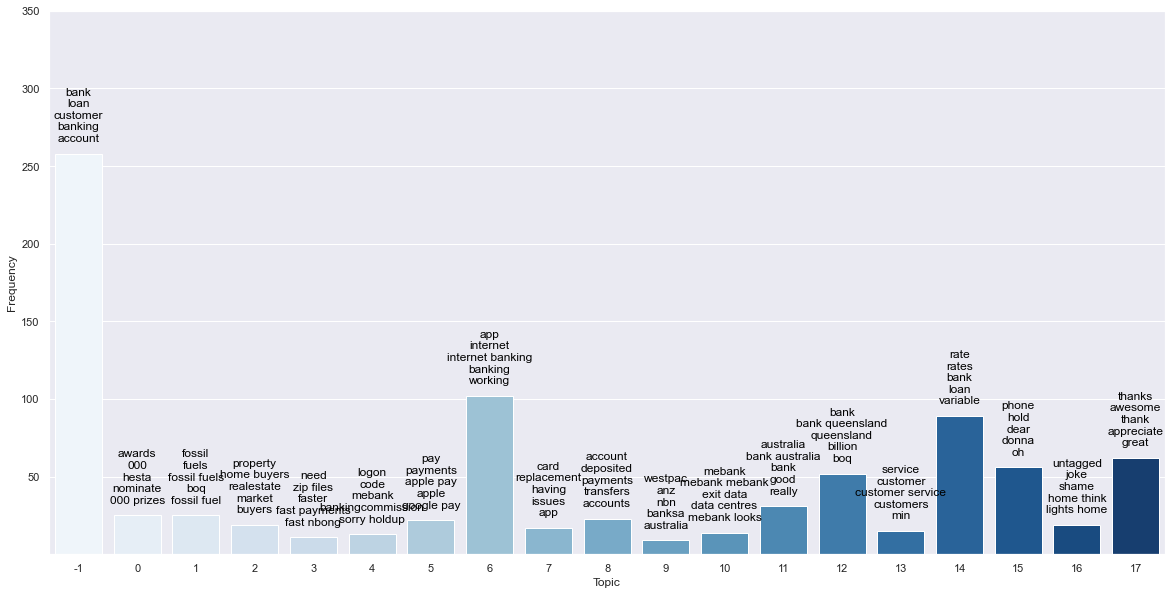

In [243]:
#plotting topics in the period 

data=clusters.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

ax = sns.barplot(x="Topic", y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.yaxis.set_ticks([50,100,150,200,250,300,350])


fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)
fig.savefig("cluster_freqs.png")


for i in range(len(clusters['Topic'])):

    n_topwords=5
    topwords=clusters.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(clusters.loc[i,'Topic']+1, clusters.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_labeled.png")

In [272]:
data=clusters.loc[:,['Topic','cluster_size','top_words']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

for i,topic in enumerate(data['Topic']):
    data.loc[i,'index']=i

data

,Topic,cluster_size,top_words,index
0,-1,258,"['bank', 'loan', 'customer', 'banking', 'accou...",0.0
1,6,102,"['app', 'internet', 'internet banking', 'banki...",1.0
2,14,89,"['rate', 'rates', 'bank', 'loan', 'variable', ...",2.0
3,17,62,"['thanks', 'awesome', 'thank', 'appreciate', '...",3.0
4,15,56,"['phone', 'hold', 'dear', 'donna', 'oh', 'just...",4.0
5,12,52,"['bank', 'bank queensland', 'queensland', 'bil...",5.0
6,11,31,"['australia', 'bank australia', 'bank', 'good'...",6.0
7,0,25,"['awards', '000', 'hesta', 'nominate', '000 pr...",7.0
8,1,25,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...",8.0
9,8,23,"['account', 'deposited', 'payments', 'transfer...",9.0


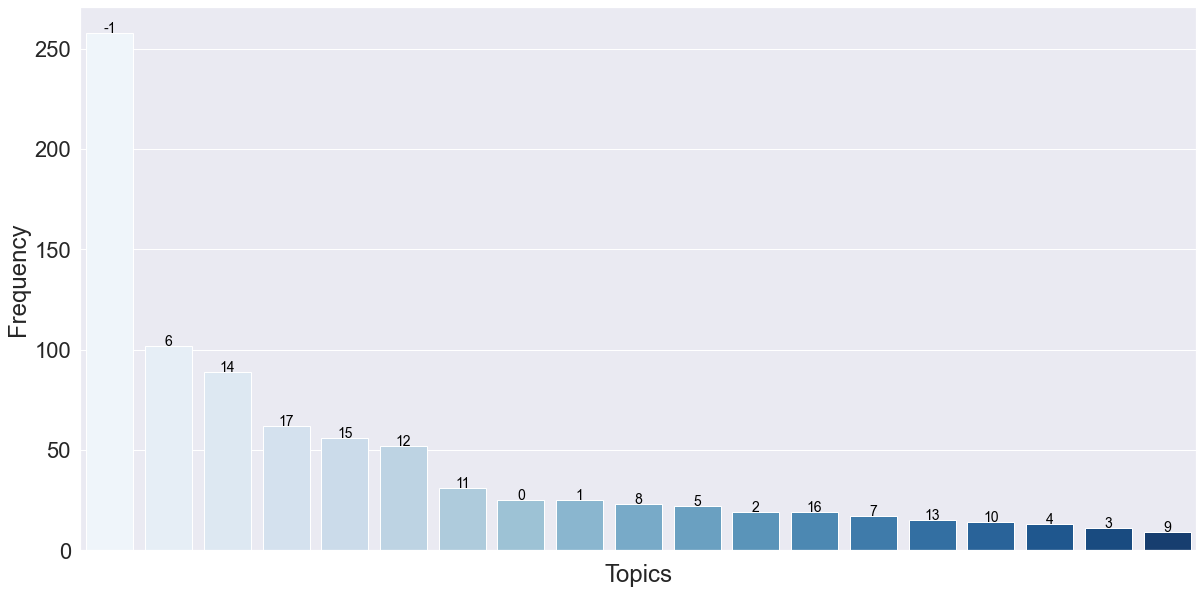

In [288]:
#plotting topics in the period 
ax = sns.barplot(x='index',y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.xaxis.set_label_text('Topics')
ax.set(xticklabels=[])

sns.set(font_scale=2) 
#ax.yaxis.set_ticks([50,100,150,200,250,300])

fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)


for i in range(len(clusters['Topic'])):

    label='{}'.format(data.loc[i,'Topic'])

    plt.annotate(label, # this is the text
                 xy=(data.loc[i,'index'], data.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=14,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_sorted_large.png")

In [97]:
# Wordcloud of Top N words in each topic
#!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)



fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict()
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [107]:
import json 
clustering_results.loc[1,'top_words_score']


"[('awards', 0.07246765771153867), ('000', 0.0606007944385828), ('hesta', 0.05569183870847809), ('nominate', 0.05569183870847809), ('000 prizes', 0.04458010449505674), ('prizes', 0.04458010449505674), ('amp', 0.04361798095312633), ('nominations', 0.04064984780876315), ('incredible', 0.04064984780876315), ('health', 0.04064984780876315)]"

BERTopic

In [2687]:
#from sentence_transformers import SentenceTransformer

#model = SentenceTransformer("paraphrase-mpnet-base-v2")
#embeddings_clean = model.encode(input_data_clean["content_clean"].values)

In [2709]:
from bertopic import BERTopic

# Create BERTopic model
topic_model = BERTopic(nr_topics='auto',
		top_n_words=10,
                n_gram_range=(1,2), 
                calculate_probabilities=True,
                embedding_model=SentenceTransformer("paraphrase-mpnet-base-v2"),
                umap_model= umap_model,
                hdbscan_model=hdbscan_model,
                verbose=True)



docs=results_cluster_sorted['content_clean']
#embeddings=np.array(results_cluster_sorted['embedding'].values.tolist())

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(docs)

Batches: 100%|██████████| 27/27 [01:53<00:00,  4.19s/it]
2021-08-06 02:44:41,117 - BERTopic - Transformed documents to Embeddings
2021-08-06 02:44:44,117 - BERTopic - Reduced dimensionality with UMAP
2021-08-06 02:44:44,174 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-08-06 02:44:58,376 - BERTopic - Reduced number of topics from 22 to 9


In [2710]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,323,-1_you_for_is_your
1,0,297,0_for_is_on_bank
2,1,118,1_to_is_app_it
3,2,31,2_fossil_to fossil_fuel_fossil fuel
4,3,31,3_rates_interest_and_interest rates
5,4,20,4_they_data_for_and
6,5,17,5_go out_tap go_interest_tap
7,6,15,6_amp_very_high_their
8,7,10,7_problem_cleared_solved_incognito with


In [2715]:
results.head(1)

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
0,2020-07-27 07:35:23,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,0,NaN,"[-0.055616923, 0.0632461, -0.03989287, -0.1368...","[17.018082, 0.8446648, 7.1081824, 10.371539, 7...",11,0.563219,0.436781


In [2725]:
timestamps=results.date.to_list()
tweets=results.content_clean.to_list()

topics_over_time = topic_model.topics_over_time(tweets, topics, timestamps)


843it [07:06,  1.98it/s]


In [2744]:
topics_over_time.sample(10)

,Topic,Words,Frequency,Timestamp,Name
720,-1,"nothing ing, love with, shame was, getting rid...",1,2021-05-29 05:03:26,-1_you_for_is_your
425,-1,"msg every, delete transfer, deleted but, the t...",1,2021-02-10 07:47:17,-1_you_for_is_your
502,1,"stimulus driven, bumper profit, banks as, quee...",1,2021-02-23 02:50:21,1_to_is_app_it
786,5,"supersex with, had supersex, supersex, with yo...",1,2021-07-04 04:04:00,5_go out_tap go_interest_tap
180,3,"lnp, super funds, super, funds, politicians had",1,2020-10-14 08:30:12,3_rates_interest_and_interest rates
223,-1,"rate, fee, paid the, they jacked, pay them",1,2020-11-06 23:44:24,-1_you_for_is_your
83,5,"down, be down, its still, updated information,...",1,2020-08-27 01:36:40,5_go out_tap go_interest_tap
699,0,"and replied, replied now, for contact, have vi...",1,2021-05-18 06:14:41,0_for_is_on_bank
51,4,"is finally, finally available, when gpay, gpay...",1,2020-08-17 02:31:24,4_they_data_for_and
175,-1,"shefali, posoldova, are excited, kalsi shefali...",1,2020-10-13 01:34:05,-1_you_for_is_your


In [ ]:
#topic_model.visualize_topics_over_time(topics_over_time)

#topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

In [2711]:
topic_model.visualize_topics()